# Dataset Preparation and Preprocessing

This Python Notebook outlines the operations performed to prepare and preprocess the XSum dataset for the fine-tuning of the Large Language Models (LLMs). The XSum Dataset contains a total of 226,706 documents and human generated summaries of the documents, which will be cut down to 37,500 records due to resource contraints.

The goal of this preparation and preprocessing step is to generate a text summarization dataset that will be used for fine-tuning the Large Language Models (LLMs) upon which their performance after the fine-tuning process will be recorded and benchmarked against one another.

<ins>Preparation and Preprocessing Operations</ins>
1. Dataset Creation
2. Dataset Cleaning
3. Data Visualization

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import json
import re

from datasets import load_dataset, DatasetDict

c:\Users\Admin\Desktop\Work\Capstone\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Creation

The XSum Dataset will be loaded with 37,500 records and a training, validation, test split of 80:10:10 will be created.

In [2]:
xsum_dataset = load_dataset("EdinburghNLP/xsum", split = "train[0:37500]")
xsum_dataset

Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 37500
})

In [3]:
train_test_split = xsum_dataset.train_test_split(test_size = 0.2, seed = 42)
test_validation_split = train_test_split["test"].train_test_split(test_size = 0.5, seed = 42)

xsum_dataset = DatasetDict({
    'train': train_test_split["train"],
    'test': test_validation_split["test"],
    'validation': test_validation_split["train"]
})

print(xsum_dataset)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 3750
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 3750
    })
})


## Dataset Cleaning

With the advancement of Large Language Models (LLMs), only basic text preprocessing is required before being used to fine-tune the models. A basic regex to remove the escape sequence ('\n') and emojis are sufficient preprocessing for the dataset. 

In [4]:
def clean_text(text):
    # text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(' +', ' ', text)
    text = text.replace('\n', '')
    return text

def clean_dataset(dataset):
    dataset = dataset.map(lambda x: {'document': clean_text(x['document']), 'summary': clean_text(x['summary'])})
    
    return dataset

xsum_dataset['train'] = clean_dataset(xsum_dataset['train'])
xsum_dataset['test'] = clean_dataset(xsum_dataset['test'])
xsum_dataset['validation'] = clean_dataset(xsum_dataset['validation'])
# dataset = clean_dataset(arxiv_dataset)

xsum_dataset

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 3750
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 3750
    })
})

In [5]:
xsum_dataset.save_to_disk("./datasets/xsum_dataset.hf")

Saving the dataset (1/1 shards): 100%|██████████| 3750/3750 [00:00<00:00, 575739.96 examples/s]


## Data Visualization

The goal of the data visualization process is to determine the amount of words found in the documents and human-generated summaries determine the context length that will be used for the fine-tuning of the Large Language Models (LLMs).

In [6]:
random_samples = xsum_dataset['train'].shuffle(seed = 42).select(range(5))

for sample in random_samples:
    print(sample)

{'document': 'Siddle joined Notts on a two-year deal ahead of last season, but did not play last summer because of a back injury.And the 32-year-old has now withdrawn from playing in the 2017 county season.Pattinson, 26, has taken 70 wickets in 17 Test matches for Australia, with his last appearance coming against New Zealand in February 2016.He took his first five-wicket haul in first-class cricket since December 2015 in Victoria\'s Sheffield Shield win over Western Australia on Saturday, a result which secured the Bushrangers a place in the final."I feel for Peter in particular because he\'s had absolutely no luck in recent years when it comes to injuries," Nottinghamshire director of cricket Mick Newell said."We certainly didn\'t imagine, when we signed him on a two-year contract for 2016 and 2017, that he wouldn\'t play a single game for us during that time."Nottinghamshire were relegated from Division One of the County Championship last season, having won just one of their 16 game

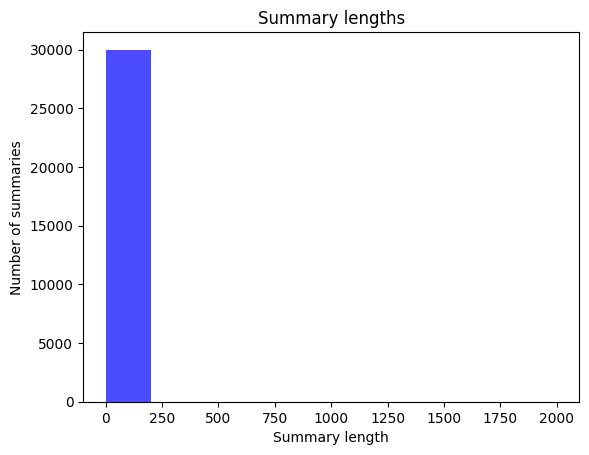

In [7]:
summaries = xsum_dataset['train']['summary']

summary_lengths = [len(summary.split()) for summary in summaries]

plt.hist(summary_lengths, range = (0, 2000), color = 'blue', alpha = 0.7)
plt.xlabel('Summary length')
plt.ylabel('Number of summaries')
plt.title('Summary lengths')
plt.show()

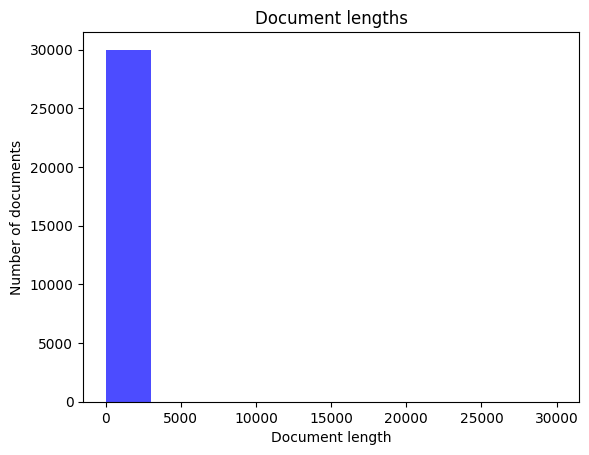

In [8]:
documents = xsum_dataset['train']['document']

document_lengths = [len(document.split()) for document in documents]

plt.hist(document_lengths, range = (0, 30000), color = 'blue', alpha = 0.7)
plt.xlabel('Document length')
plt.ylabel('Number of documents')
plt.title('Document lengths')
plt.show()

In [ ]:
xsum_dataset.push_to_hub("woshityj/xsum_dataset", token = "XXXXXXXXXXXXXXXX")

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/woshityj/xsum_dataset/commit/8656c50447da99bcab4defbe36c09d241a4c55cf', commit_message='Upload dataset', commit_description='', oid='8656c50447da99bcab4defbe36c09d241a4c55cf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/woshityj/xsum_dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='woshityj/xsum_dataset'), pr_revision=None, pr_num=None)